In [77]:
import math
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
accuracy_score, precision_score, recall_score, f1_score,
roc_auc_score, roc_curve, confusion_matrix
)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Suppress overflow warnings from sklearn/numpy
warnings.filterwarnings("ignore", category=RuntimeWarning)
np.seterr(over='ignore')

sns.set(style='whitegrid', context='notebook')

#Check device for NN
device = (
    torch.device("cuda") if torch.cuda.is_available() # nvidia
    else torch.device("mps") if torch.backends.mps.is_available() # apple silicon gpu
    else torch.device("cpu")
)

In [78]:
df = pd.read_csv('coffee_survey.csv')

df.head()

,submission_id,age,cups,where_drink,brew,brew_other,purchase,purchase_other,favorite,favorite_specify,...,spent_equipment,value_equipment,gender,gender_specify,education_level,ethnicity_race,ethnicity_race_specify,employment_status,number_children,political_affiliation
0,gMR29l,18-24 years old,NaN,NaN,NaN,NaN,NaN,NaN,Regular drip coffee,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BkPN0e,25-34 years old,NaN,NaN,Pod/capsule machine (e.g. Keurig/Nespresso),NaN,NaN,NaN,Iced coffee,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,W5G8jj,25-34 years old,NaN,NaN,Bean-to-cup machine,NaN,NaN,NaN,Regular drip coffee,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4xWgGr,35-44 years old,NaN,NaN,Coffee brewing machine (e.g. Mr. Coffee),NaN,NaN,NaN,Iced coffee,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,QD27Q8,25-34 years old,NaN,NaN,Pour over,NaN,NaN,NaN,Latte,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
df.isnull().sum()

submission_id                      0
age                               31
cups                              93
where_drink                       70
brew                             385
brew_other                      3364
purchase                        3332
purchase_other                  4011
favorite                          62
favorite_specify                3928
additions                         83
additions_other                 3994
dairy                           2356
sweetener                       3530
style                             84
strength                         126
roast_level                      102
caffeine                         125
expertise                        104
coffee_a_bitterness              244
coffee_a_acidity                 263
coffee_a_personal_preference     253
coffee_a_notes                  1464
coffee_b_bitterness              262
coffee_b_acidity                 275
coffee_b_personal_preference     269
coffee_b_notes                  1588
c

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4042 entries, 0 to 4041
Data columns (total 57 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   submission_id                 4042 non-null   object 
 1   age                           4011 non-null   object 
 2   cups                          3949 non-null   object 
 3   where_drink                   3972 non-null   object 
 4   brew                          3657 non-null   object 
 5   brew_other                    678 non-null    object 
 6   purchase                      710 non-null    object 
 7   purchase_other                31 non-null     object 
 8   favorite                      3980 non-null   object 
 9   favorite_specify              114 non-null    object 
 10  additions                     3959 non-null   object 
 11  additions_other               48 non-null     object 
 12  dairy                         1686 non-null   object 
 13  swe

<Axes: >

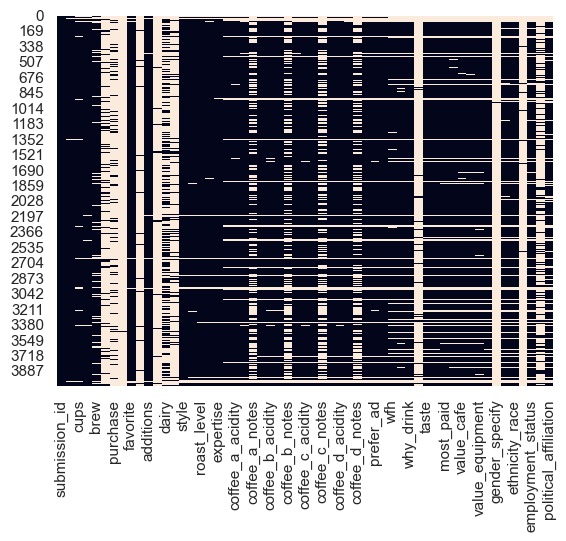

In [81]:
sns.heatmap(df.isnull(), cbar=False)


In [82]:
# drop rows where target variable is null
df = df.dropna(subset=['roast_level'])

### Features that seem important
- target: roast_level

- age, cups, where_drink, brew, favorite, additions, dairy, style, caffeine, expertise, prefer_abc, prefer_ad, prefer_overall, wfh, total_spend, why_drink (im guessing people who drink for taste will like lighter roasts bc of specialty coffee), taste, know_source, most_paid, most_willing, value_cafe, spent_equipment, gender, education_level, ethnicity_race, employment_status, number_children, political_affiliation (use some sources for the report for this - liberal latte etc...)

- coffee abcd ratings (the tasting notes column is useful but i dont know how I could encode/quantify this since its so variable, but i think if someone is able to describe the notes in detail they are more likely to enjoy it)

- brew_other, purchase, sweetener -> could be useful but mostly null

In [83]:
ordinal_important = ['age', 'cups', 'expertise', 'roast_level']

nominal_important = ['where_drink', 'brew', 'favorite', 'style',]

ordinal_trivial = ['caffeine', 'total_spend', 'most_paid', 'most_willing', 'spent_equipment', 'education_level', 'number_children', ]

nominal_trivial = ['additions', 'dairy','wfh', 'why_drink', 'taste', 'know_source', 'value_cafe', 'gender', 'ethnicity_race', 'employment_status', 'political_affiliation']

# lets not use tasting notes for now because its unclear how to quantify or categorize this data
# this is ordinal
sensory_rankings = [
    'coffee_a_bitterness',
    'coffee_a_acidity',
    'coffee_a_personal_preference',
    # 'coffee_a_notes',
    'coffee_b_bitterness',
    'coffee_b_acidity',
    'coffee_b_personal_preference',
    # 'coffee_b_notes',
    'coffee_c_bitterness',
    'coffee_c_acidity',
    'coffee_c_personal_preference',
    # 'coffee_c_notes',
    'coffee_d_bitterness',
    'coffee_d_acidity',
    'coffee_d_personal_preference',
    # 'coffee_d_notes',
]

features = ordinal_important + nominal_important + ordinal_trivial + nominal_trivial + sensory_rankings
df = df[features]

In [84]:
# clean data

# fix spelling for consistency
df['brew'] = df['brew'].str.replace('Pour over', 'Pourover', regex=False)

# remove 'years old' from age
df['age'] = df['age'].str.replace(' years old', '').str.strip()

# lets map numeric string values of cups to numeric values
# drinking 3 cups of coffee is significantly more caffeine than drinking 1 cup
cups_mapping = {
    'Less than 1': 0.5, # assumption
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    'More than 4': 5 # anybody drinking 5+ cups a day is a major outlier anyway
}
df['cups'] = df['cups'].map(cups_mapping)

children_mapping = {
    '1': 1,
    '2': 2,
    '3': 3,
    'More than 3': 4
}
df['number_children'] = df['number_children'].map(children_mapping)
df['number_children'] = df['number_children'].fillna(0)



# we just want to classify for light/medium/dark, so lets place rare roast_level values into those categories
# Nordic and Blonde are light roasts. French and Italian roasts are dark
roast_map = {
    'Nordic': 'Light',
    'Blonde': 'Light',
    'French': 'Dark',
    'Italian': 'Dark',
}

df['roast_level'] = df['roast_level'].replace(roast_map)

df = df.rename(columns={'roast_level': 'stated_roast_level'})

abcd_map = {
    'a': 'Light',
    'b': 'Medium',
    'c': 'Dark',
    'd': 'Light',
}

# handle columns that have comma seperated lists inside each value
csv_cols = ['brew', 'where_drink', 'additions', 'dairy', 'why_drink']
for csv_col in csv_cols:
    df[csv_col] = df[csv_col].str.split(',\s*')  # split by comma + optional spaces

    # Step 2: Use .explode() to turn lists into individual rows
    exploded = df.explode(csv_col)

    # Step 3: One-hot encode, then group back by index
    dummies = pd.get_dummies(exploded[csv_col], prefix=csv_col).groupby(exploded.index).sum()

    # Step 4: Combine back with your original dataframe (if you want)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(csv_col, axis=1)

df

,age,cups,expertise,roast_level,favorite,style,caffeine,total_spend,most_paid,most_willing,...,dairy_Half and half,dairy_Oat milk,dairy_Skim milk,dairy_Soy milk,dairy_Whole milk,why_drink_I need the caffeine,why_drink_I need the ritual,why_drink_It makes me go to the bathroom,why_drink_It tastes good,why_drink_Other
13,<18,2.0,NaN,Light,Other,Full Bodied,Full caffeine,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
14,25-34,1.0,7.0,Light,Pourover,Fruity,Full caffeine,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
15,<18,3.0,10.0,Light,Pourover,Bright,Full caffeine,>$100,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
16,>65,3.0,7.0,Light,Cortado,Fruity,Full caffeine,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
17,25-34,1.0,6.0,Medium,Regular drip coffee,Sweet,Full caffeine,$40-$60,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4037,>65,2.0,2.0,Medium,Regular drip coffee,Chocolatey,Full caffeine,$20-$40,$6-$8,$4-$6,...,0,0,1,0,0,0,0,0,1,0
4038,>65,2.0,2.0,Light,Regular drip coffee,Nutty,Full caffeine,$20-$40,$4-$6,$2-$4,...,0,0,1,0,0,1,0,0,0,0
4039,18-24,1.0,5.0,Light,Latte,Sweet,Full caffeine,$40-$60,$8-$10,More than $20,...,0,1,0,0,0,0,1,1,1,0
4040,25-34,2.0,6.0,Medium,Iced coffee,Nutty,Full caffeine,$20-$40,$4-$6,$8-$10,...,0,0,0,0,1,1,1,0,1,0


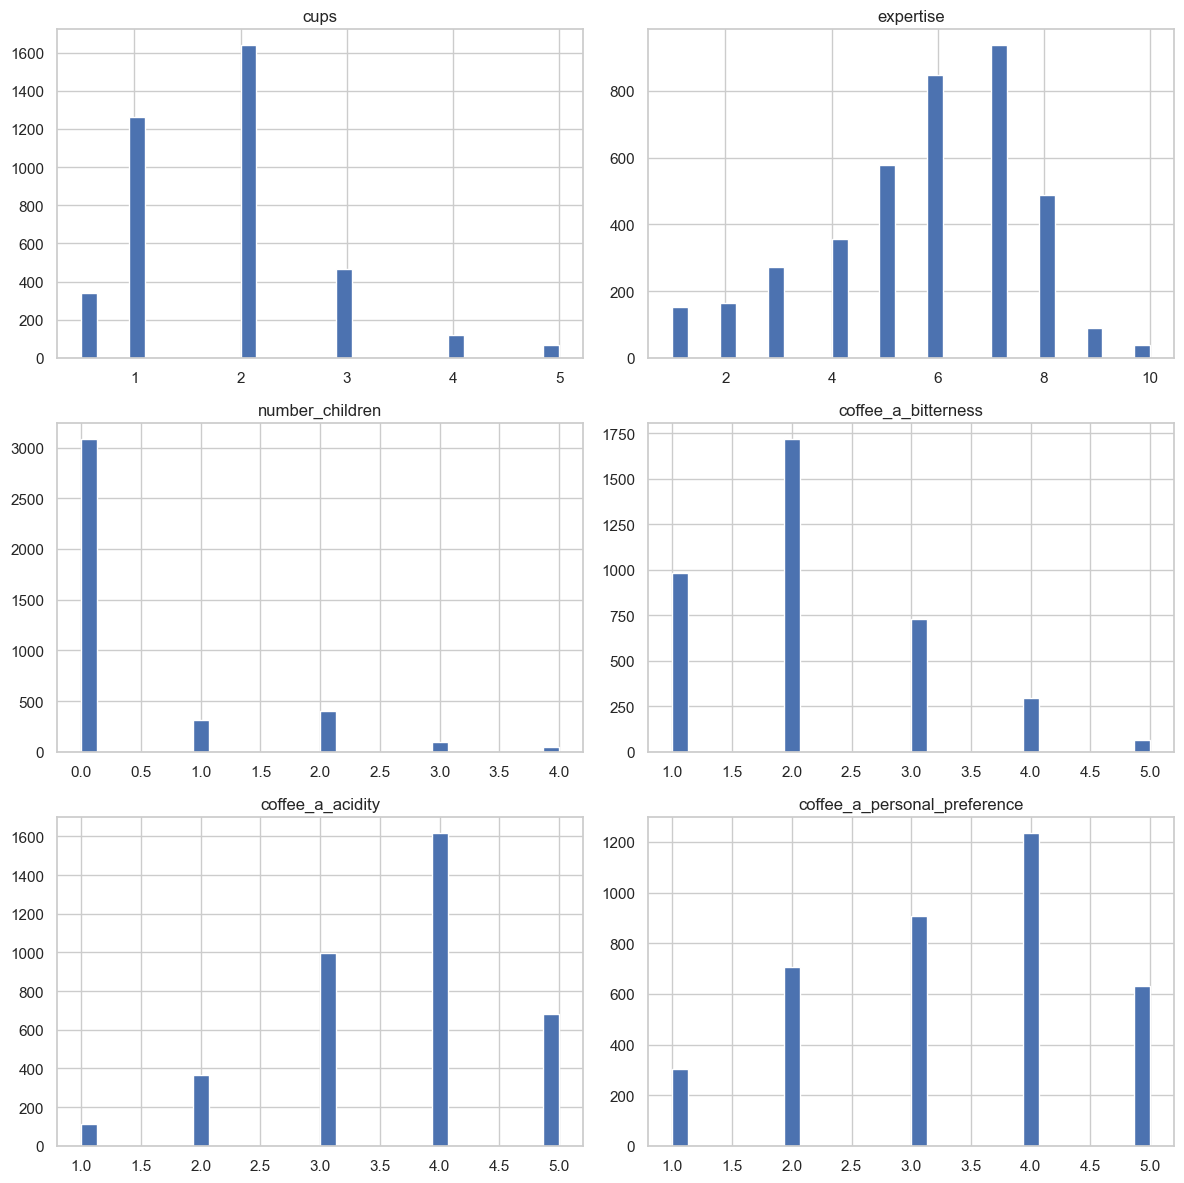

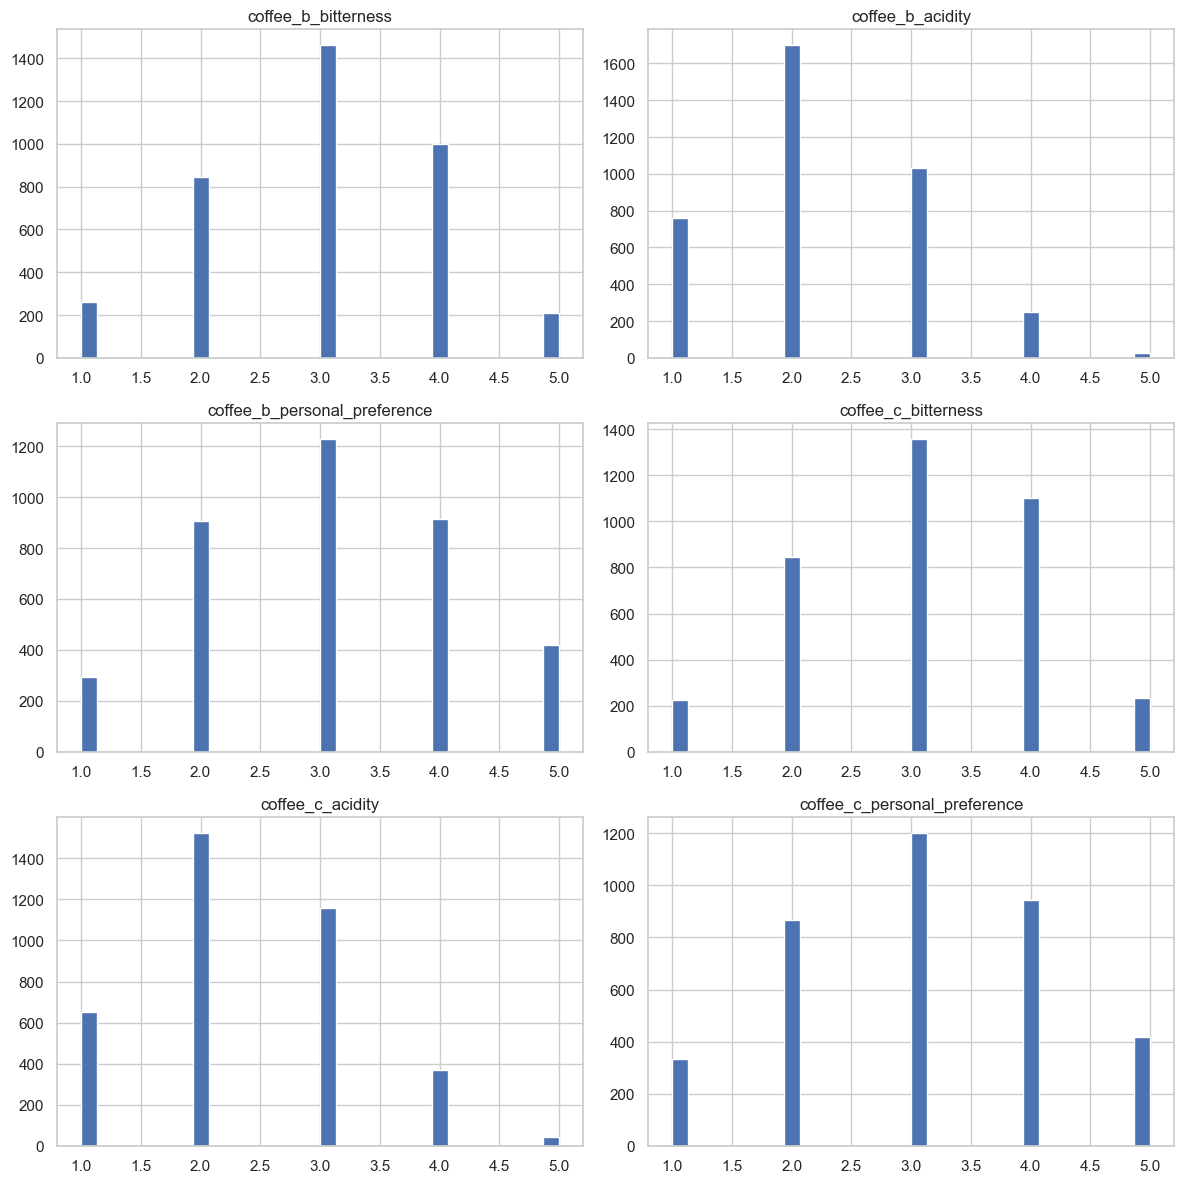

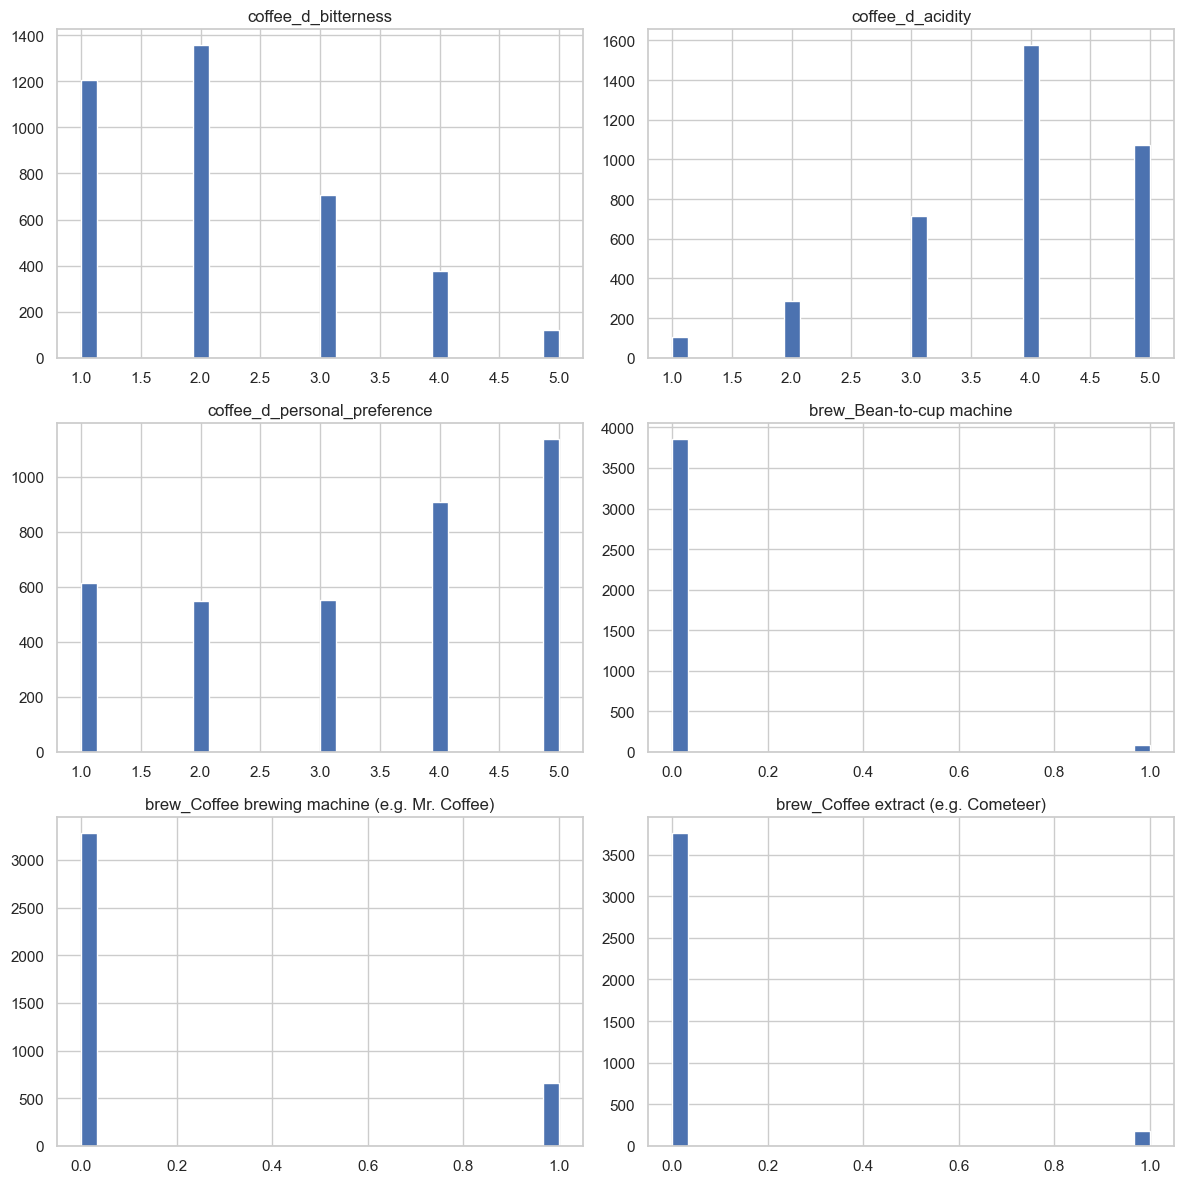

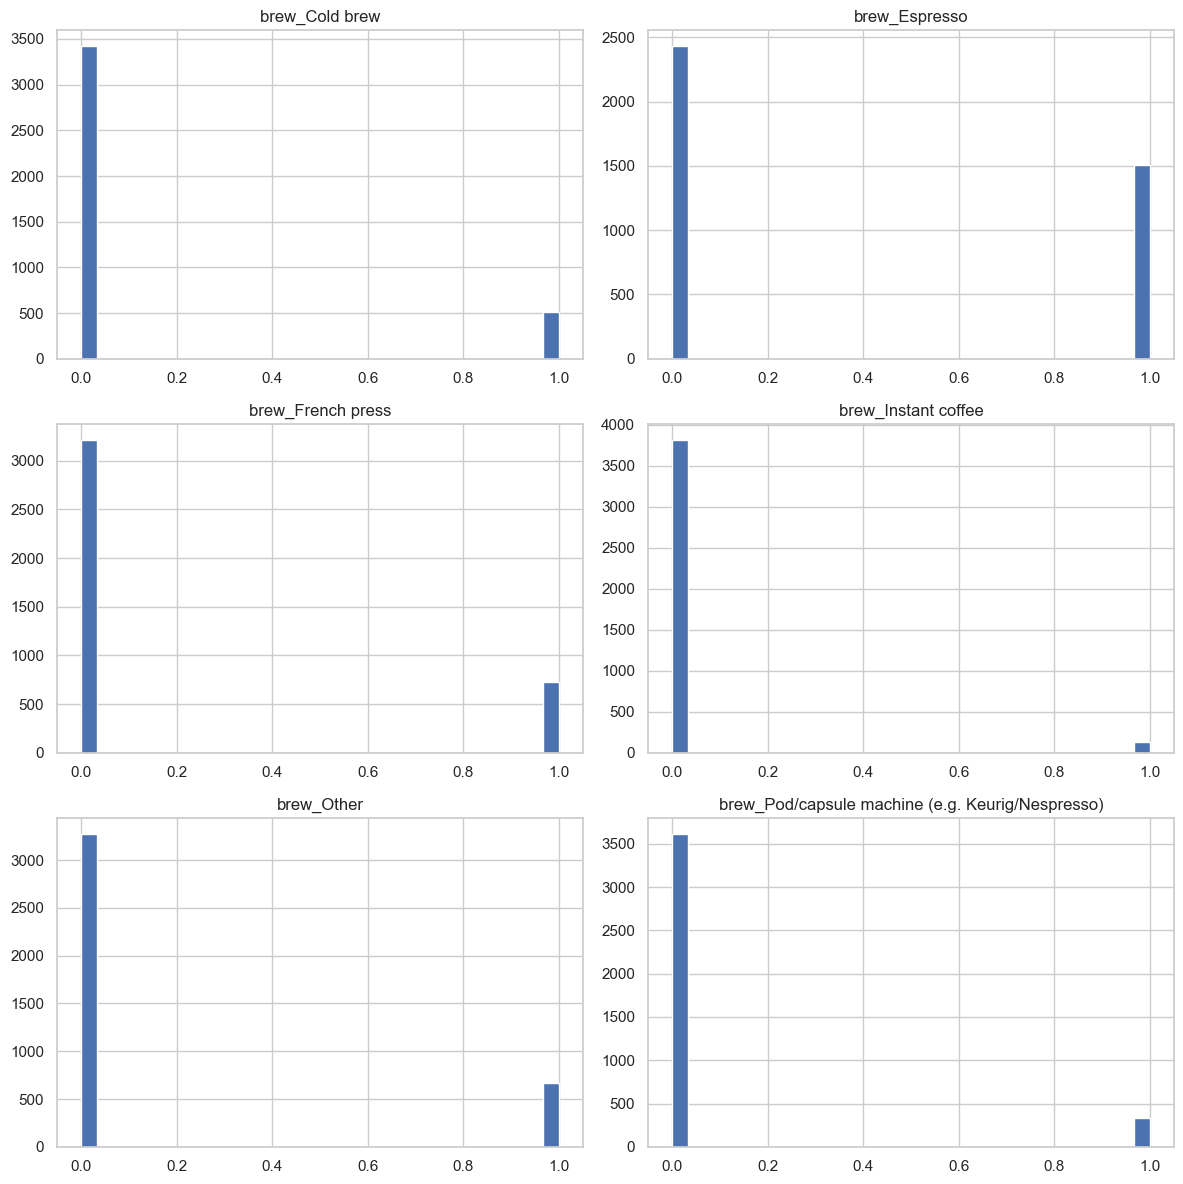

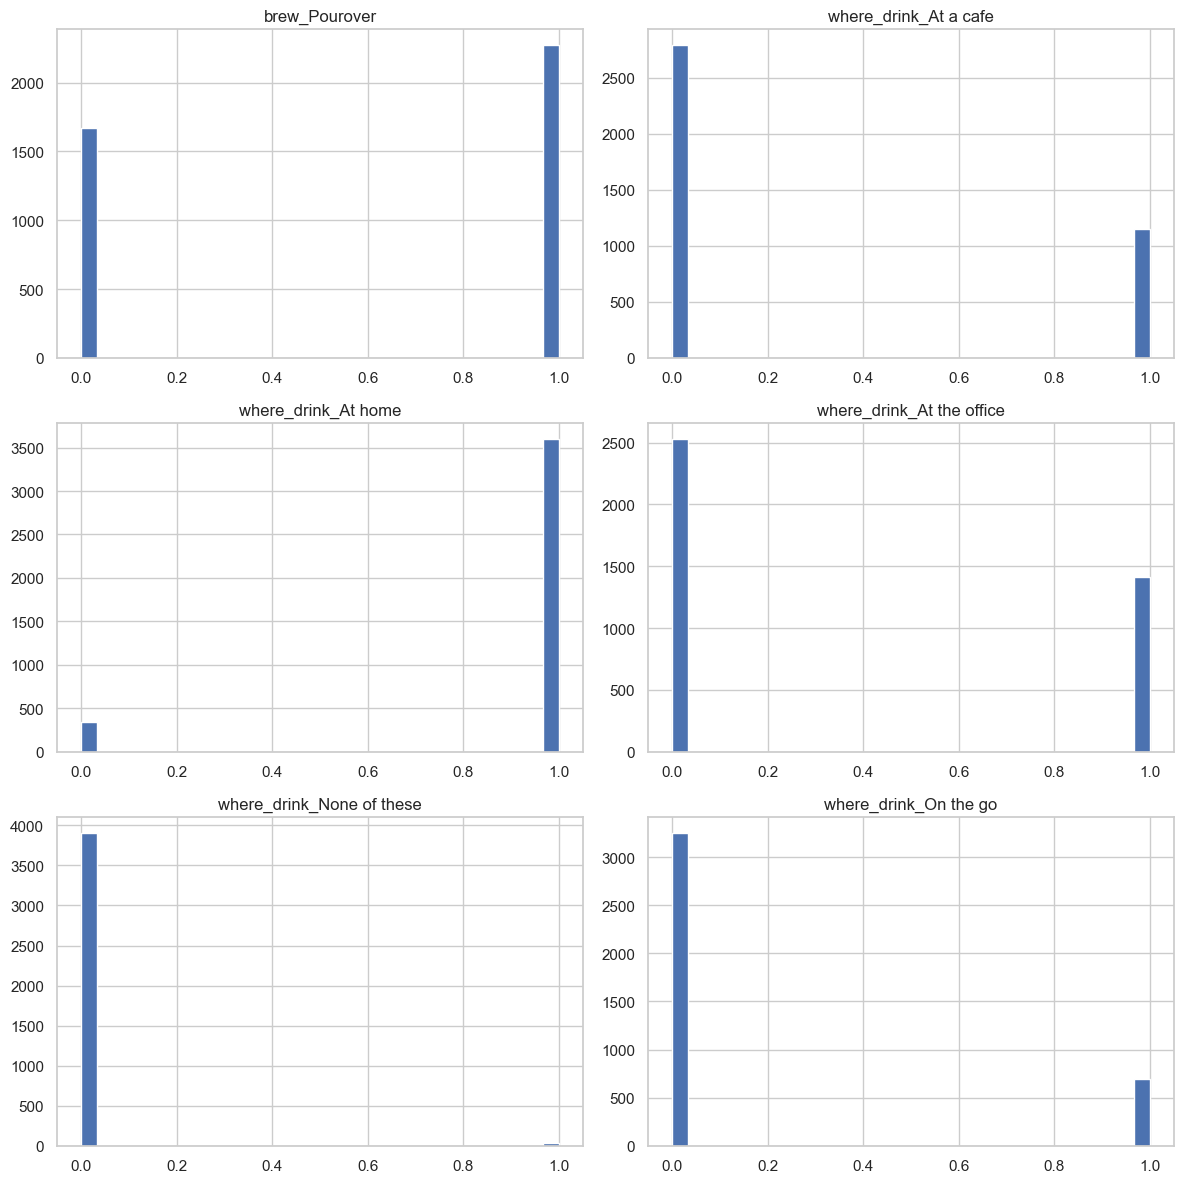

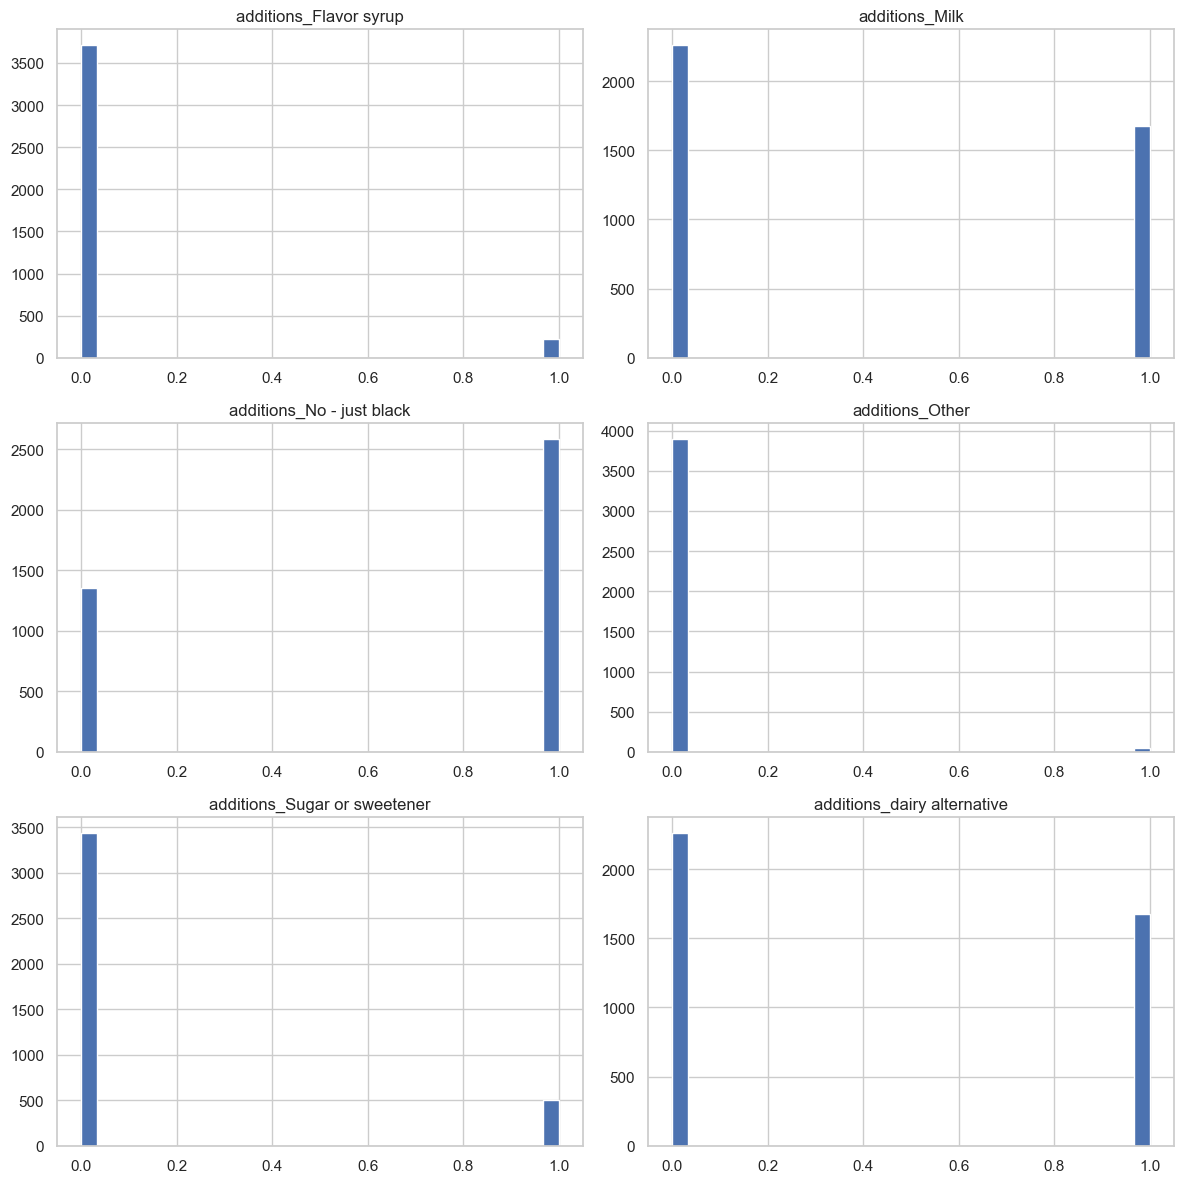

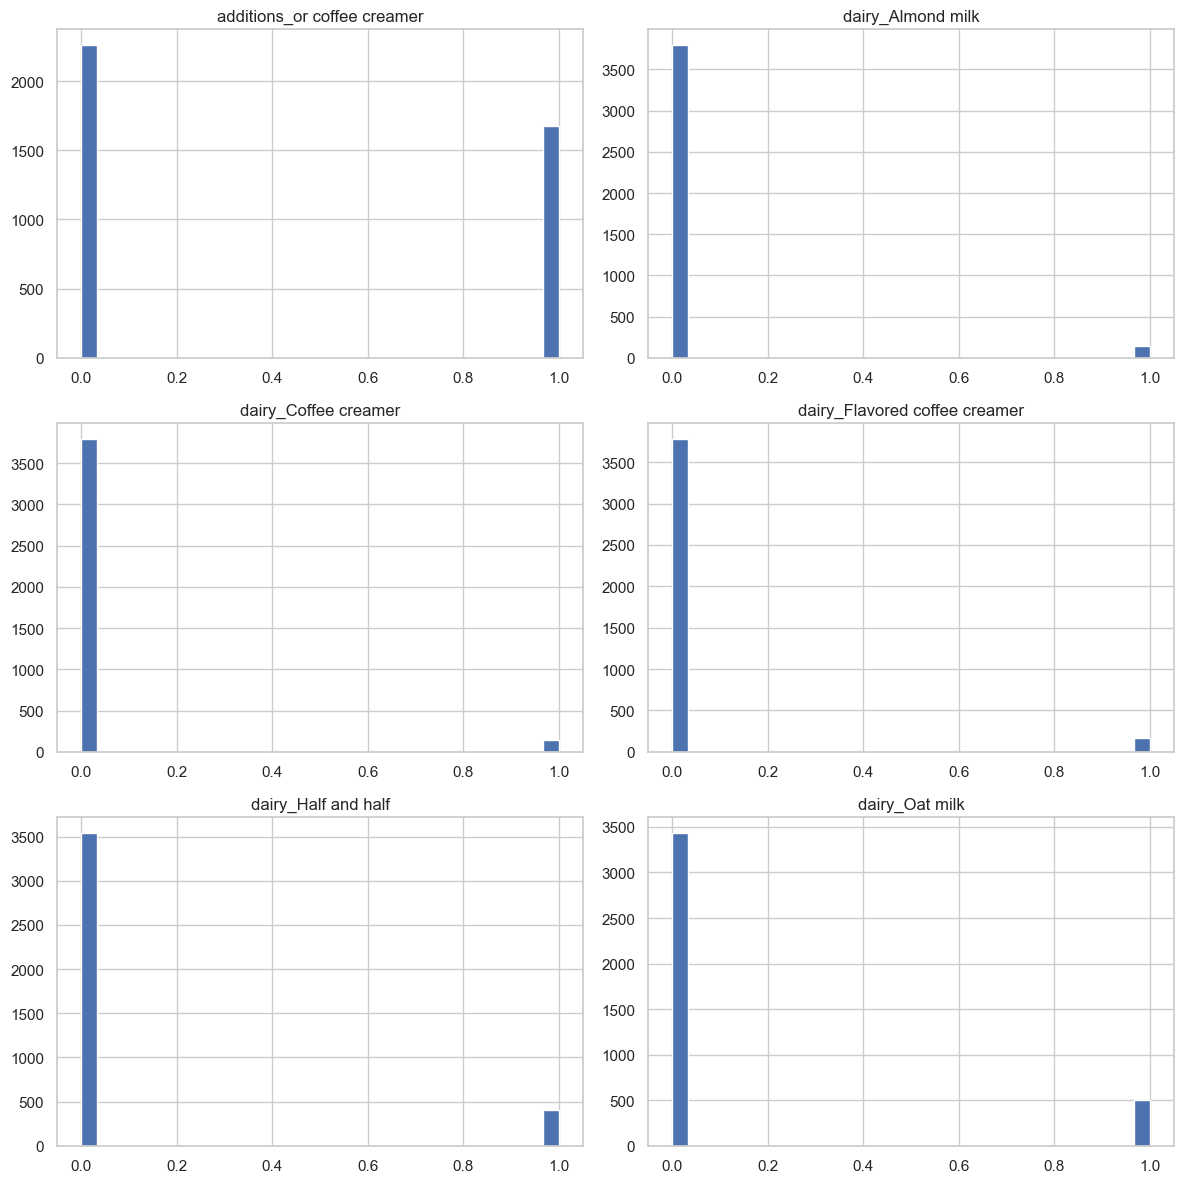

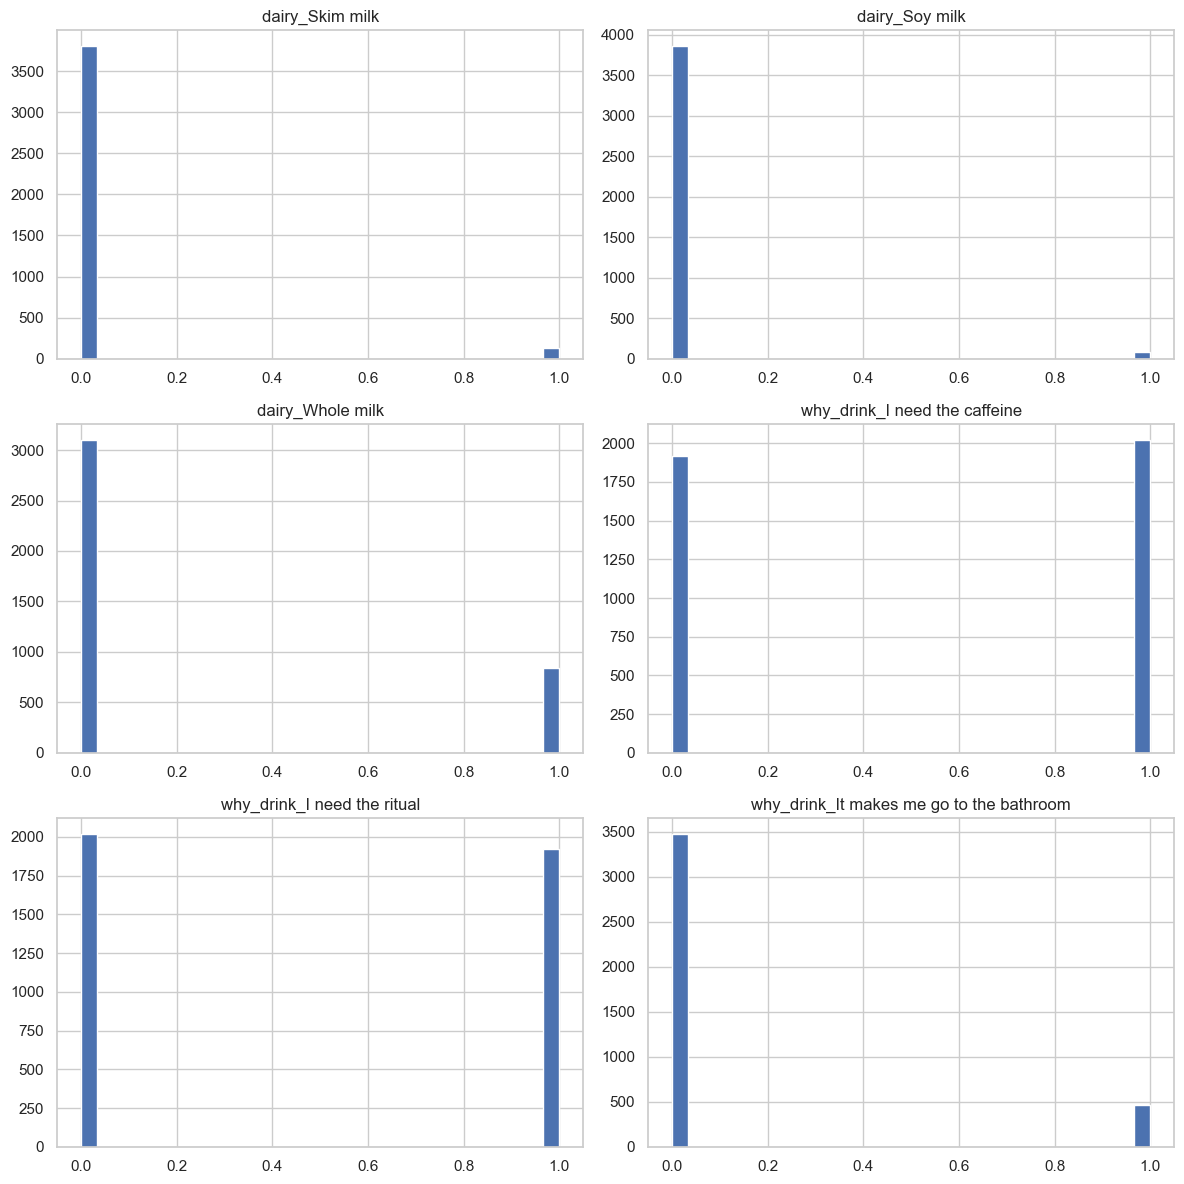

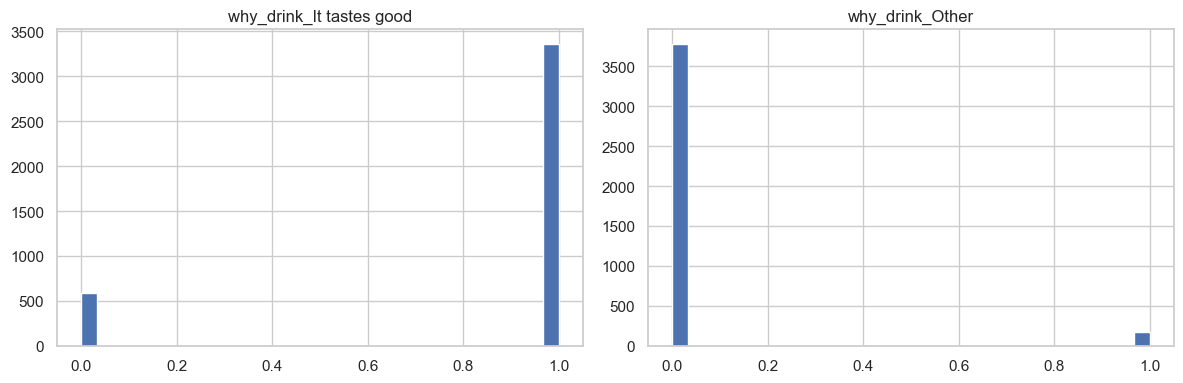

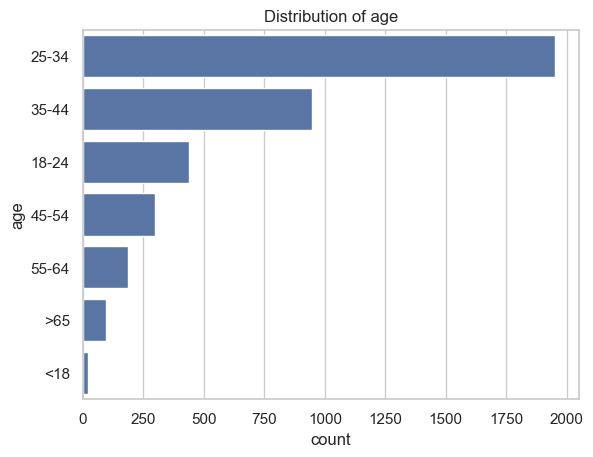

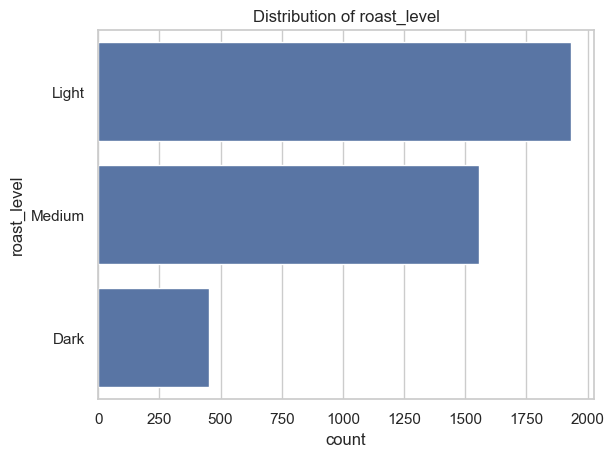

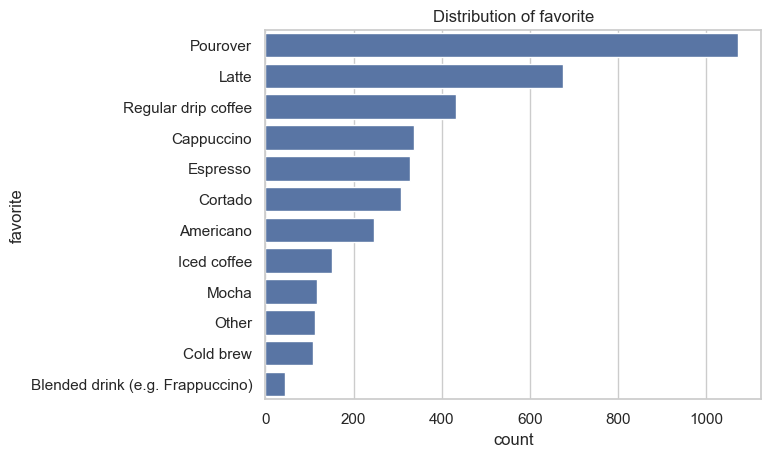

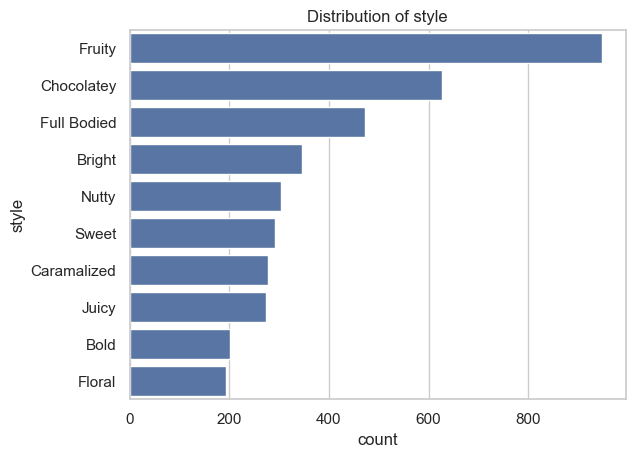

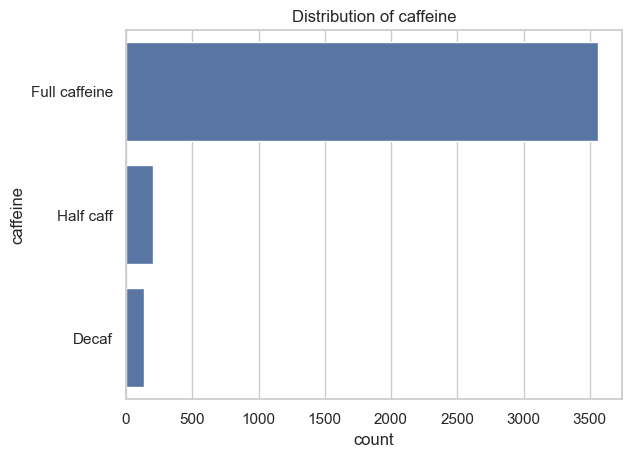

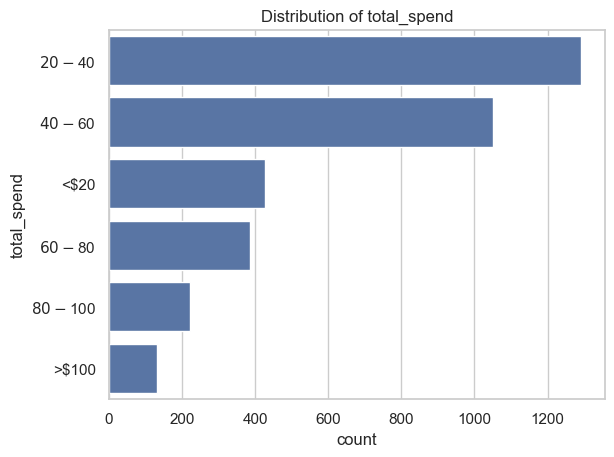

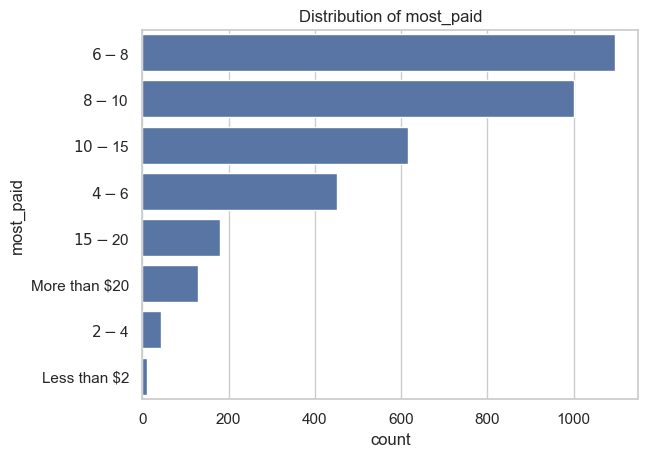

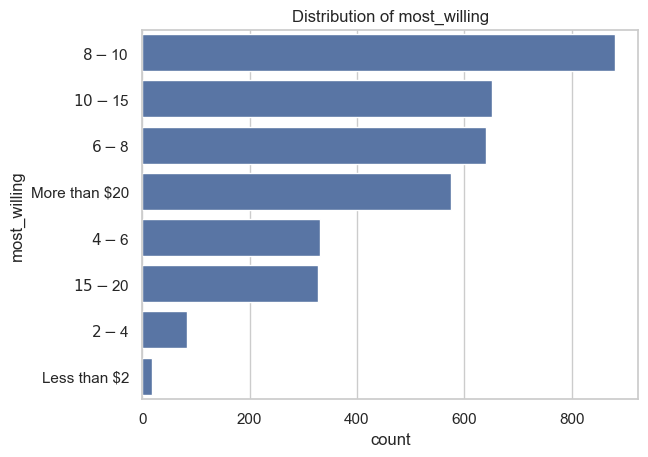

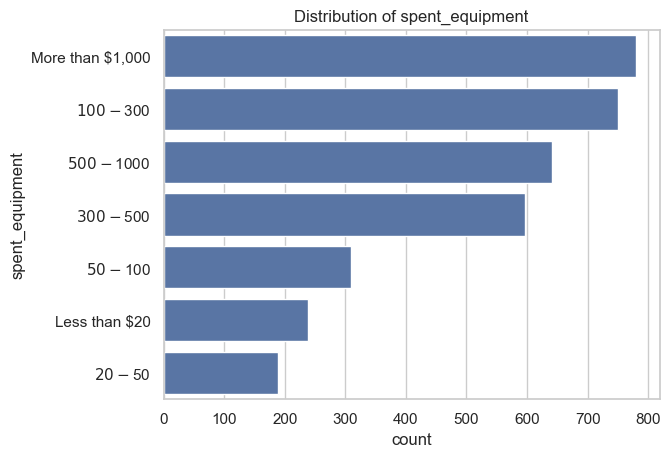

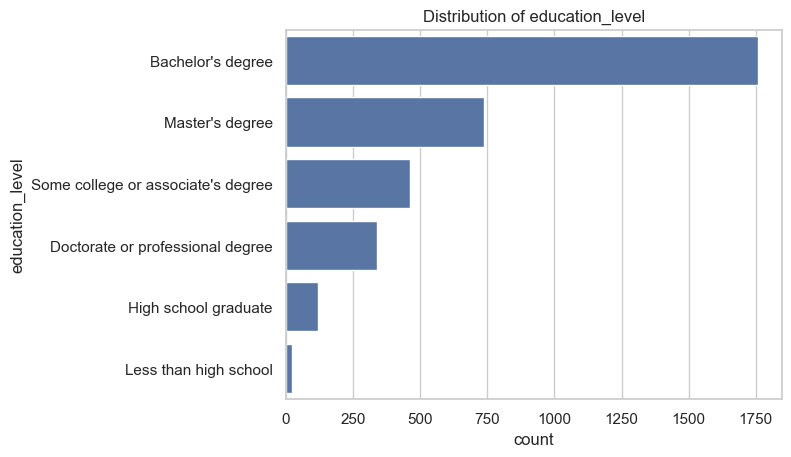

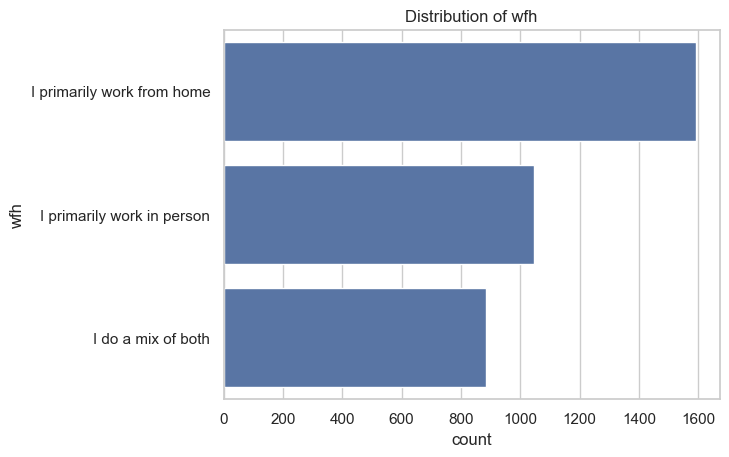

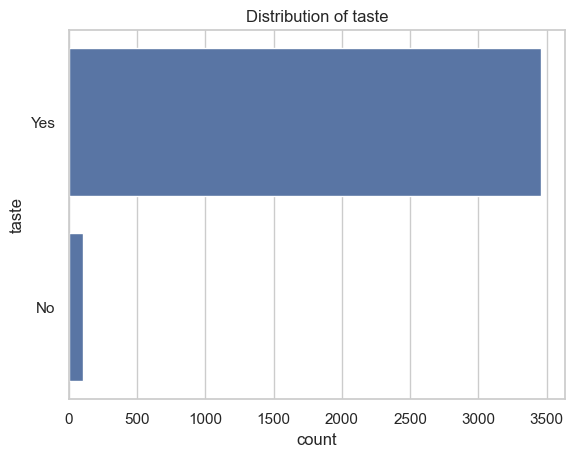

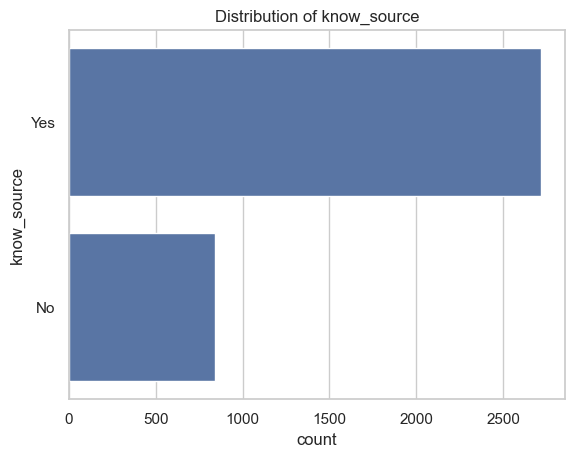

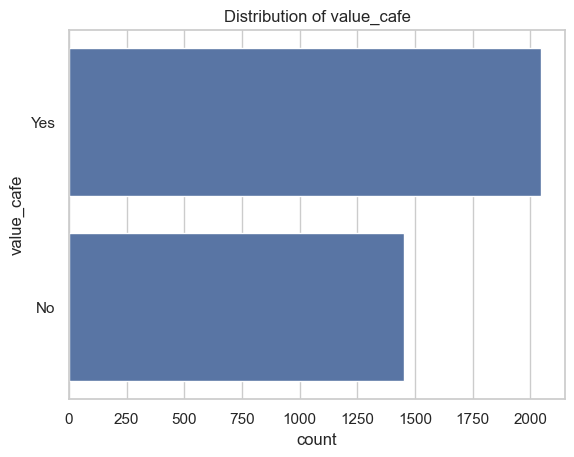

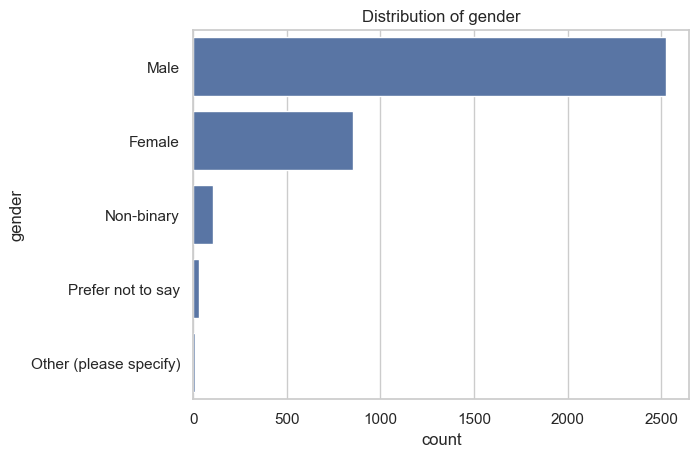

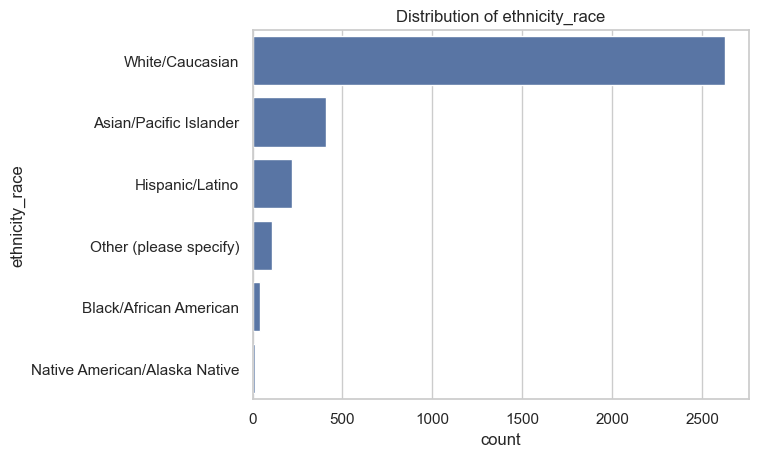

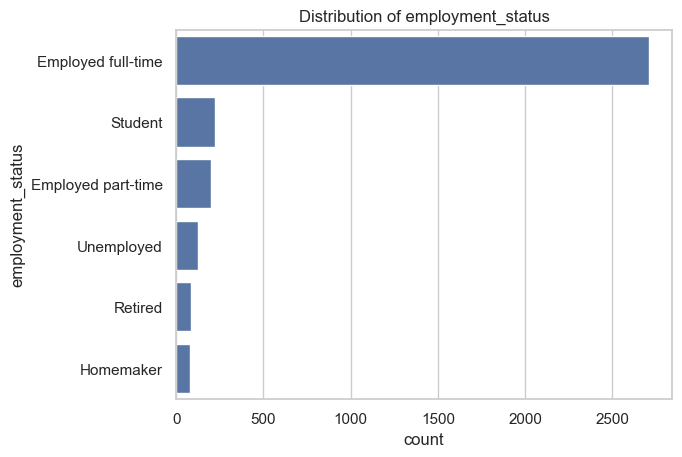

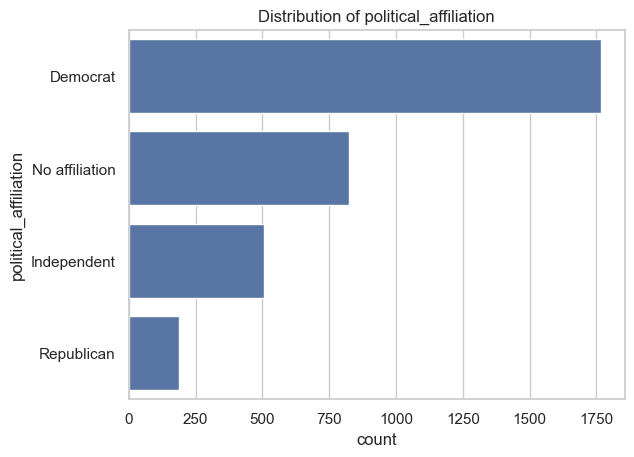

In [85]:
# distributions (its all categorical)
num_cols = df.select_dtypes('number').columns
cat_cols = df.select_dtypes('object').columns

# Numeric
# df[num_cols].hist(bins=30, figsize=(12, 6))
# plt.tight_layout()
# plt.show()

# Number of numeric columns
n_cols = len(num_cols)

# Decide how many plots per figure (e.g., 6)
plots_per_fig = 6

# Number of figures needed
n_figs = math.ceil(n_cols / plots_per_fig)

for i in range(n_figs):
    cols = num_cols[i*plots_per_fig : (i+1)*plots_per_fig]
    n_subplots = len(cols)

    # Determine rows/columns layout
    n_rows = math.ceil(n_subplots / 2)
    n_cols_fig = 2

    fig, axes = plt.subplots(n_rows, n_cols_fig, figsize=(12, 4*n_rows))
    axes = axes.flatten()  # flatten in case of single row

    for ax, col in zip(axes, cols):
        df[col].hist(bins=30, ax=ax)
        ax.set_title(col)

    # Hide unused subplots
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Categorical
for csv_col in cat_cols:
    sns.countplot(y=csv_col, data=df, order=df[csv_col].value_counts().index)
    plt.title(f"Distribution of {csv_col}")
    plt.show()

In [86]:
# reduce the number of features by combining rare one hot encoded values

# drop features that won't be useful

# optional: drop csv columns because they explode col count
prefixes = ['brew', 'where_drink', 'additions', 'dairy', 'why_drink']

for prefix in prefixes:
    cols_to_drop = [col for col in df.columns if col.startswith(prefix)]
    df = df.drop(columns=cols_to_drop)

df = df.drop(columns=['taste']) # almost everybody answered yes so probably not that predictive of a feature

print(df.isnull().sum()[df.isnull().sum() > 0])

age                               9
cups                             46
expertise                        18
favorite                         10
style                             7
caffeine                         36
total_spend                     430
most_paid                       413
most_willing                    430
spent_equipment                 434
education_level                 502
wfh                             417
know_source                     381
value_cafe                      440
gender                          417
ethnicity_race                  522
employment_status               521
political_affiliation           651
coffee_a_bitterness             148
coffee_a_acidity                166
coffee_a_personal_preference    156
coffee_b_bitterness             165
coffee_b_acidity                178
coffee_b_personal_preference    172
coffee_c_bitterness             181
coffee_c_acidity                193
coffee_c_personal_preference    178
coffee_d_bitterness         

In [87]:
# save dataframe
df.to_csv('coffee_survey_processed.csv', index=False)